In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# pytorch imports
import torch
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import random
from tqdm import tqdm_notebook as tqdm
import math
import time
from IPython.core.debugger import set_trace

In [3]:
bs = 64
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

In [4]:
FOOD_PATH = "./food-101"
IMG_PATH = FOOD_PATH+"/images"
META_PATH = FOOD_PATH+"/meta"
TRAIN_PATH = FOOD_PATH+"/train"
VALID_PATH = FOOD_PATH+"/valid"
MODEL_PATH = 'model_data/'

In [5]:
gpu = True if torch.cuda.is_available() else False
gpu

True

In [6]:
filename = MODEL_PATH+'clr.pth'

In [7]:
def pp_(*args, n_dash=120):
    for arg in args:
        print(arg)
        print("-"*n_dash)

In [8]:
def list_dir(path="./"): return os.listdir(path)

In [9]:
def save_checkpoint(model, is_best, filename='model_data/checkpoint.pth'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")
        
# from fastai library
def load_checkpoint(model, filename = 'model_data/checkpoint.pth'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

In [10]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(model, path):
    model.load_state_dict(torch.load(path))

In [11]:
def calc_iters(dataset, num_epochs, bs):
    return int(len(dataset) * num_epochs /bs)

In [12]:
def accuracy(output, target, is_test=False):
    global total
    global correct
    batch_size = output.shape[0]
    total += batch_size
    
    _, pred = torch.max(output, 1)
    if is_test:
        preds.extend(pred)
    correct += (pred == target).sum()
    return 100 * correct / total

In [13]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

In [14]:
def freeze(model):
    child_counter = 0
    for name, child in model.named_children():
        if child_counter < 7:
            print("name ",name, "child ",child_counter," was frozen")
            for param in child.parameters():
                param.requires_grad = False
        elif child_counter == 7:
            children_of_child_counter = 0
            for children_of_child in child.children():
                if children_of_child_counter < 2:
                    for param in children_of_child.parameters():
                        param.requires_grad = False
                    print("name ",name, 'child ', children_of_child_counter, 'of child',child_counter,' was frozen')
                else:
                    print("name ",name, 'child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
                children_of_child_counter += 1

        else:
            print("name ",name, "child ",child_counter," was not frozen")
        child_counter += 1

In [15]:
def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True

In [16]:
def print_frozen_state(model):
    child_counter = 0
    for name, child in model.named_children():
        for param in child.parameters():
            if param.requires_grad == True:
                print("child ",child_counter,"named:",name," is unfrezed")
            elif param.requires_grad == False:
                print("child ",child_counter,"named:",name," is frezed")
        child_counter += 1

In [17]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [19]:
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [20]:
class FOOD101():
    def __init__(self):
        self.train_ds, self.valid_ds, self.train_cls, self.valid_cls = [None]*4
        self.imgenet_mean = imagenet_stats[0]
        self.imgenet_std = imagenet_stats[1]
   
    def get_data_extract(self):
        if "food-101" in os.listdir():
            print("Dataset already exists")
        else:
            print("Downloading the data...")
            !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
            print("Dataset downloaded!")
            print("Extracting data..")
            !tar xzvf food-101.tar.gz
            print("Extraction done!")
        
    def _get_tfms(self):
        train_tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])
        
        valid_tfms = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])        
        return train_tfms, valid_tfms            
            
    def get_dataset(self,root_dir='./food-101/'):
        train_tfms, valid_tfms = self._get_tfms() # transformations
        self.train_ds = datasets.ImageFolder(root=TRAIN_PATH, transform=train_tfms)
        self.valid_ds = datasets.ImageFolder(root=VALID_PATH, transform=valid_tfms)        
        self.train_classes = self.train_ds.classes
        self.valid_classes = self.valid_ds.classes

        assert self.train_classes==self.valid_classes
        return self.train_ds, self.valid_ds, self.train_classes

    
    def get_dls(self, train_ds, valid_ds, bs, **kwargs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
               DataLoader(valid_ds, batch_size=bs//2, shuffle=False, **kwargs))
    
food = FOOD101()

In [21]:
food.get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [29]:
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [30]:
pp_(list_dir(FOOD_PATH), list_dir(IMG_PATH), list_dir(META_PATH))

['images', 'meta', 'README.txt', 'license_agreement.txt']
------------------------------------------------------------------------------------------------------------------------
['creme_brulee', 'sushi', 'spaghetti_bolognese', 'donuts', 'filet_mignon', 'carrot_cake', 'chicken_wings', 'oysters', 'risotto', 'spring_rolls', 'fried_rice', 'grilled_cheese_sandwich', 'spaghetti_carbonara', 'pad_thai', 'pork_chop', 'ice_cream', 'eggs_benedict', 'seaweed_salad', 'baby_back_ribs', 'cheese_plate', 'onion_rings', 'chicken_curry', 'huevos_rancheros', 'bibimbap', 'miso_soup', 'baklava', 'french_onion_soup', 'waffles', 'guacamole', 'cheesecake', 'lobster_roll_sandwich', 'bruschetta', 'shrimp_and_grits', 'bread_pudding', 'pho', 'beef_tartare', 'fried_calamari', 'strawberry_shortcake', 'hot_dog', 'chocolate_cake', 'poutine', 'panna_cotta', 'edamame', 'crab_cakes', 'greek_salad', 'beet_salad', 'samosa', 'prime_rib', 'gnocchi', 'takoyaki', 'beignets', 'lobster_bisque', 'ceviche', 'tiramisu', 'cup_cakes

In [24]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [25]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


In [26]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")

In [32]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data(META_PATH+'/train.txt', IMG_PATH, TRAIN_PATH)

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [34]:
# Prepare validation data by copying images from food-101/images to food-101/valid using the file test.txt
print("Creating validation data...")
prepare_data(META_PATH+'/test.txt', IMG_PATH, VALID_PATH)

Creating validation data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copyi

In [35]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [36]:
# Check how many files are in the test folder
print("Total number of samples in validation folder")
!find food-101/valid -type d -or -type f -printf '.' | wc -c

Total number of samples in validation folder
25250


In [37]:
train_ds, valid_ds, classes =  food.get_dataset()
num_classes = len(classes)
pp_(classes,num_classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [38]:
train_dl, valid_dl = food.get_dls(train_ds, valid_ds, bs=bs, num_workers=2)

In [39]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
    
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset
    
    def __repr__(self):
        return str(self.__class__.__name__)+" obj (train & valid DataLoaders)"

In [40]:
data = DataBunch(train_dl, valid_dl, c=num_classes)

In [41]:
pp_(data.valid_ds, data.c, data.train_ds)

Dataset ImageFolder
    Number of datapoints: 25250
    Root location: ./food-101/valid
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
------------------------------------------------------------------------------------------------------------------------
101
------------------------------------------------------------------------------------------------------------------------
Dataset ImageFolder
    Number of datapoints: 75750
    Root location: ./food-101/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
-------------------------------------------------------

In [45]:
# This can be used to print predictions too
def show_ds(trainset, classes, validset=None, cols=6, rows=17, preds=None, is_pred=False, is_valid=False):        
    fig = plt.figure(figsize=(25,25))
    fig.suptitle(f"Showing one random image from each {'Validation' if is_valid else 'Train'} classes", y=0.92, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
    columns = cols
    rows = rows
    imgenet_mean = imagenet_stats[0]
    imgenet_std = imagenet_stats[1]  

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred and testset:
            img_xy = np.random.randint(len(testset));
            np_img = testset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))            
            img = img * imgenet_std + imgenet_mean
        else:
            img_xy = np.random.randint(len(trainset));
            np_img = trainset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))
            img = img * imgenet_std + imgenet_mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(img, interpolation='nearest')
    plt.show()

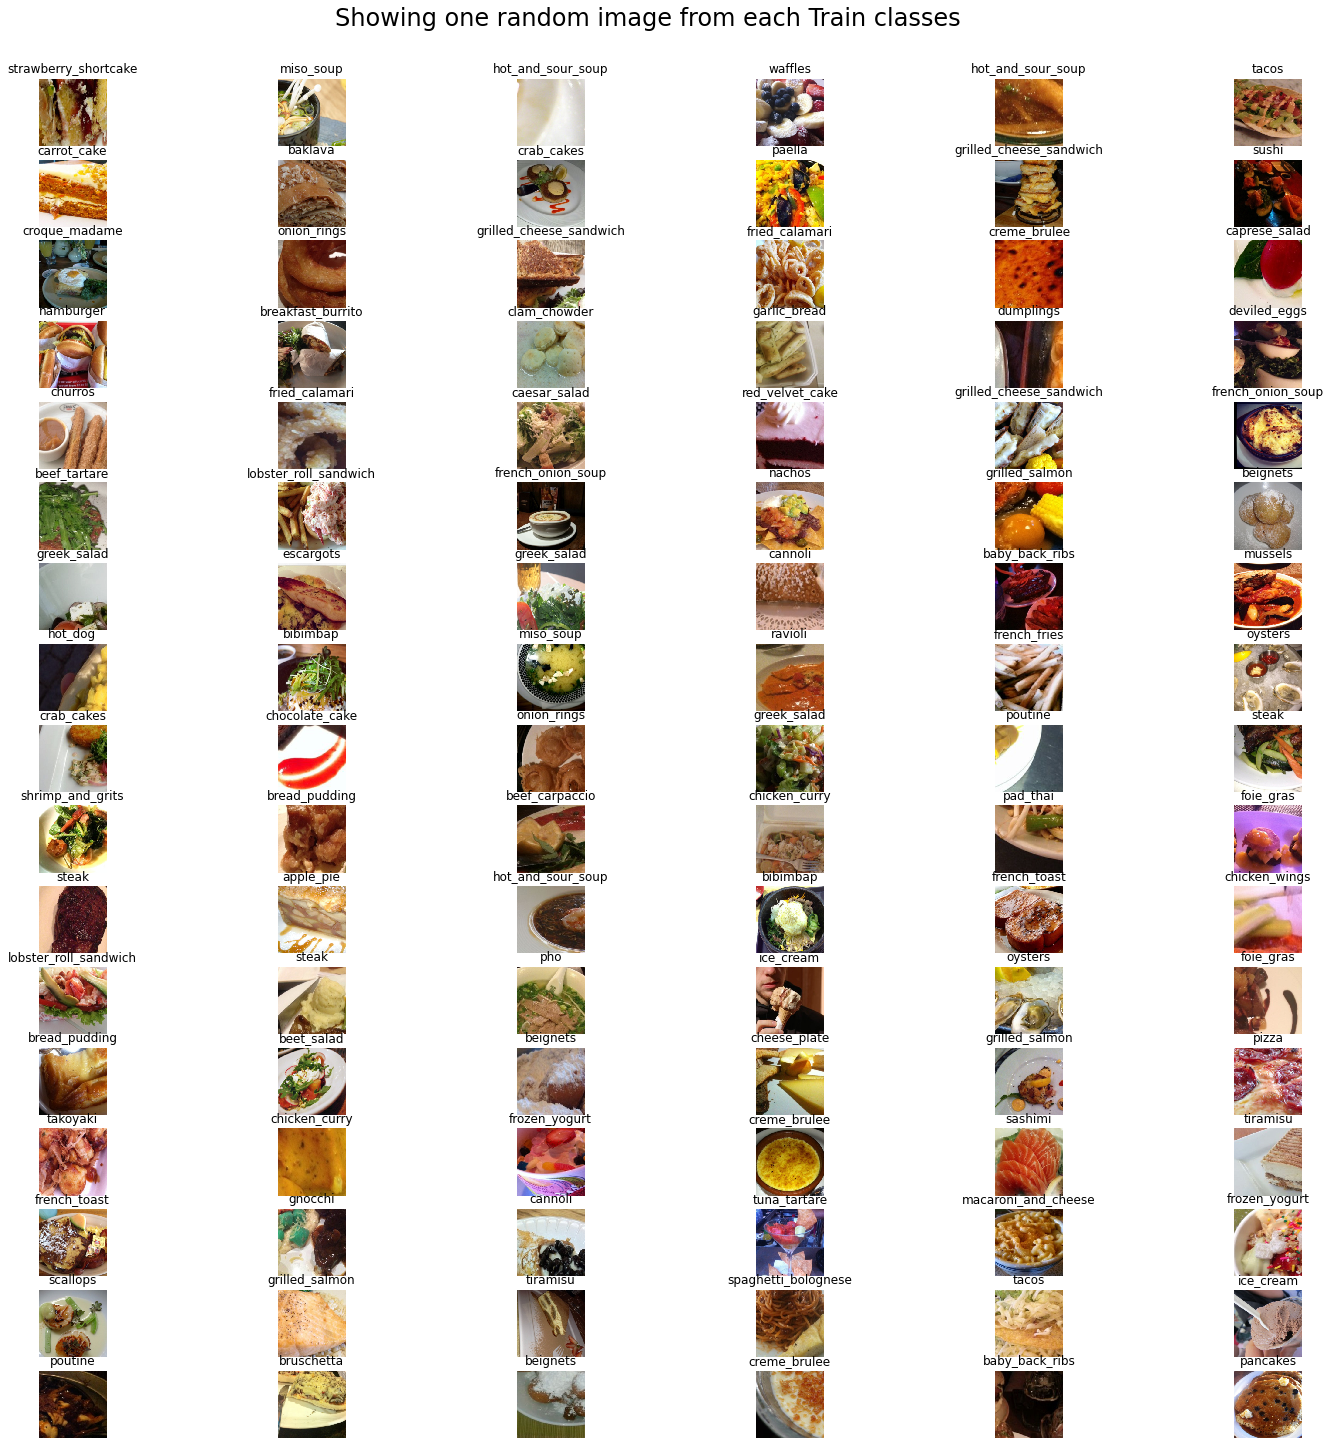

In [46]:
show_ds(data.train_ds, classes)

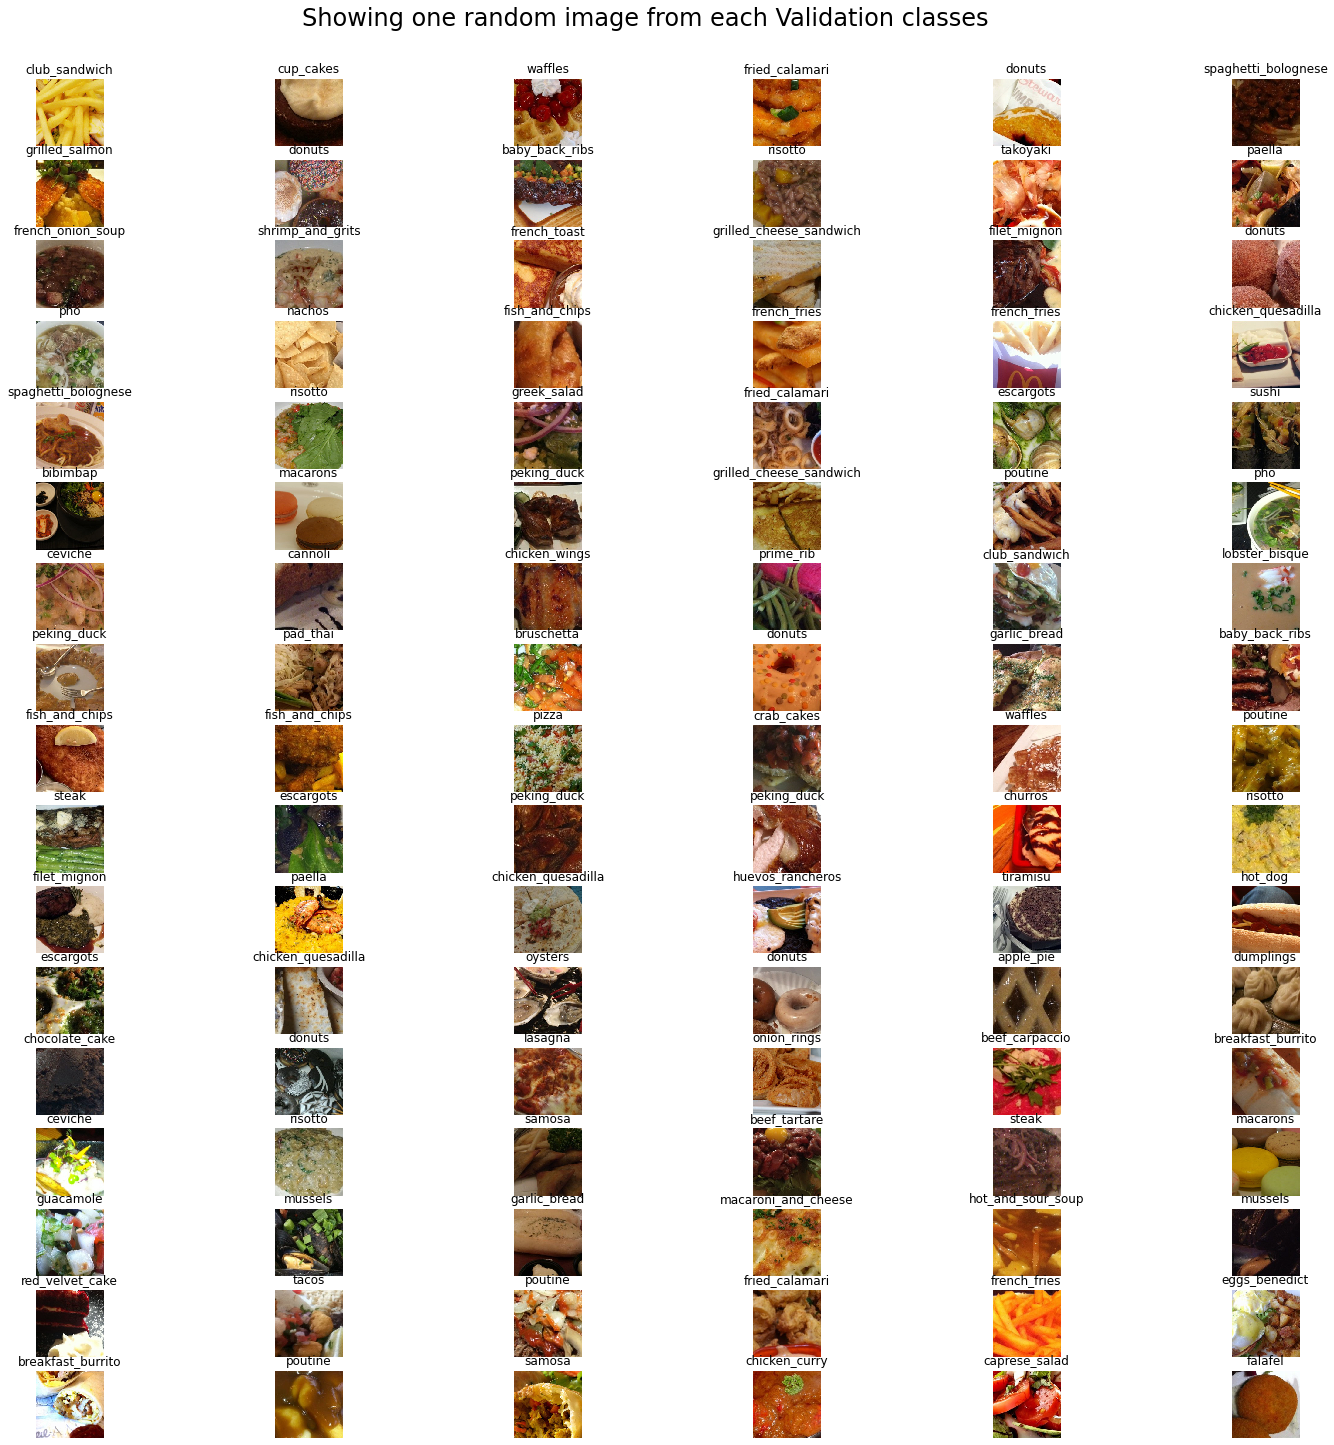

In [47]:
show_ds(data.valid_ds, classes, is_valid=True)

In [48]:
loss_func=nn.CrossEntropyLoss()

In [49]:
def get_model(lr=3e-3,num_classes=num_classes, opt="SGD", **kwargs):
    model_imgnet = models.resnet50(pretrained=True) # model
    num_ftrs = model_imgnet.fc.in_features
    model_imgnet.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
    model = model_imgnet.to(device)
#     print(model)
    if opt=="SGD":
        return model, optim.SGD(model.parameters(), lr=lr, **kwargs)
    elif opt=="Adam":
        return model, optim.Adam(model.parameters(), lr=lr, **kwargs)
    else:
        return model, optim.RMSprop(model.parameters(), lr=lr, **kwargs)

In [50]:
class Learner():
    """
    stores Model, Optimizer, Loss Function and Datasets (train & valid)
    """
    def __init__(self, model, opt, loss_func, data ):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data

In [51]:
learn = Learner(*get_model(momentum=0.9, weight_decay=1e-4, nesterov=True), loss_func, data)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [52]:
learn.loss_func = nn.CrossEntropyLoss()
learn.opt = torch.optim.SGD(learn.model.parameters(), lr=1e-4, momentum=0.95, weight_decay=1e-4)

In [53]:
pp_(learn.data, learn.loss_func, learn.opt) #, learn.model)

DataBunch obj (train & valid DataLoaders)
------------------------------------------------------------------------------------------------------------------------
CrossEntropyLoss()
------------------------------------------------------------------------------------------------------------------------
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.95
    nesterov: False
    weight_decay: 0.0001
)
------------------------------------------------------------------------------------------------------------------------


In [54]:
freeze(learn.model)

name  conv1 child  0  was frozen
name  bn1 child  1  was frozen
name  relu child  2  was frozen
name  maxpool child  3  was frozen
name  layer1 child  4  was frozen
name  layer2 child  5  was frozen
name  layer3 child  6  was frozen
name  layer4 child  0 of child 7  was frozen
name  layer4 child  1 of child 7  was frozen
name  layer4 child  2 of child 7  was not frozen
name  avgpool child  8  was not frozen
name  fc child  9  was not frozen


In [55]:
# %load OneCycle.py
class OneCycle(object):
    """
    In paper (https://arxiv.org/pdf/1803.09820.pdf), author suggests to do one cycle during 
    whole run with 2 steps of equal length. During first step, increase the learning rate 
    from lower learning rate to higher learning rate. And in second step, decrease it from 
    higher to lower learning rate. This is Cyclic learning rate policy. Author suggests one 
    addition to this. - During last few hundred/thousand iterations of cycle reduce the 
    learning rate to 1/100th or 1/1000th of the lower learning rate.

    Also, Author suggests that reducing momentum when learning rate is increasing. So, we make 
    one cycle of momentum also with learning rate - Decrease momentum when learning rate is 
    increasing and increase momentum when learning rate is decreasing.

    Args:
        nb              Total number of iterations including all epochs

        max_lr          The optimum learning rate. This learning rate will be used as highest 
                        learning rate. The learning rate will fluctuate between max_lr to
                        max_lr/div and then (max_lr/div)/div.

        momentum_vals   The maximum and minimum momentum values between which momentum will
                        fluctuate during cycle.
                        Default values are (0.95, 0.85)

        prcnt           The percentage of cycle length for which we annihilate learning rate
                        way below the lower learnig rate.
                        The default value is 10

        div             The division factor used to get lower boundary of learning rate. This
                        will be used with max_lr value to decide lower learning rate boundary.
                        This value is also used to decide how much we annihilate the learning 
                        rate below lower learning rate.
                        The default value is 10.
    """
    def __init__(self, nb, max_lr, momentum_vals=(0.95, 0.85), prcnt= 10 , div=10):
        self.nb = nb
        self.div = div
        self.step_len =  int(self.nb * (1- prcnt/100)/2)
        self.high_lr = max_lr
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        self.prcnt = prcnt
        self.iteration = 0
        self.lrs = []
        self.moms = []
        
    def calc(self):
        self.iteration += 1
        lr = self.calc_lr()
        mom = self.calc_mom()
        return (lr, mom)
        
    def calc_lr(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        if self.iteration > 2 * self.step_len:
            ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
            lr = self.high_lr * ( 1 - 0.99 * ratio)/self.div
        elif self.iteration > self.step_len:
            ratio = 1- (self.iteration -self.step_len)/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        else :
            ratio = self.iteration/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        self.lrs.append(lr)
        return lr
    
    def calc_mom(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        if self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        self.moms.append(mom)
        return mom

In [56]:
bs

64

In [57]:
total = 0
correct = 0

train_loss = 0
test_loss = 0
best_acc = 0
trn_losses = []
trn_accs = []
val_losses = []
val_accs = []

preds =[]

In [58]:
train_stats = AvgStats()
test_stats = AvgStats()

In [59]:
def train(epoch=0, use_cycle = False, model=learn.model):
    model.train()
    global best_acc
    global trn_accs, trn_losses
    is_improving = True
    counter = 0
    running_loss = 0.
    avg_beta = 0.98
    t1 = tqdm(learn.data.train_dl, leave=False, total=int(len(learn.data.train_dl)))
        
    for i, (input, target) in enumerate(t1):
        bt_start = time.time()
        if gpu :
            input, target = input.cuda(), target.cuda() 
        else :
            input, target = input.cpu(), target.cpu()
        var_ip, var_tg = Variable(input), Variable(target)
                
        if use_cycle:    
            lr, mom = onecycle.calc()
            update_lr(learn.opt, lr)
            update_mom(learn.opt, mom)
            
        output = model(var_ip)
        loss = learn.loss_func(output, var_tg)
            
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        
        trn_losses.append(smoothed_loss)
            
        # measure accuracy and record loss
        prec = accuracy(output.data, target)
        trn_accs.append(prec)

        train_stats.append(smoothed_loss, prec, time.time()-bt_start)
        if prec > best_acc :
            best_acc = prec
            save_checkpoint(model, True)

        # compute gradient and do SGD step
        learn.opt.zero_grad()
        loss.backward()
        learn.opt.step()

In [60]:
def validate(model=learn.model):
    avg_beta = 0.98
    model.eval()
    global val_accs, val_losses
    running_loss = 0.
    t2 = tqdm(learn.data.valid_dl, leave=False, total=int(len(learn.data.valid_dl)))
    with torch.no_grad():
        for i, (input, target) in enumerate(t2):
            bt_start = time.time()
            if gpu :
                input, target = input.cuda(), target.cuda() 
            else :
                input, target = input.cpu(), target.cpu()
            var_ip, var_tg = Variable(input), Variable(target)
            output = model(var_ip)
            loss = learn.loss_func(output, var_tg)

            running_loss = avg_beta * running_loss + (1-avg_beta) *loss
            smoothed_loss = running_loss / (1 - avg_beta**(i+1))

            # measure accuracy and record loss
            prec = accuracy(output.data, target, is_test=True)
            test_stats.append(loss, prec, time.time()-bt_start)

            val_losses.append(smoothed_loss)
            val_accs.append(prec)

In [61]:
def fit(epochs, use_onecycle=False, model=learn.model):
    print(f"{'epoch':5s}{'train_loss':>15s}{'valid_loss':>15s}{'train_acc':>15s}{'valid_acc':>15s}")
    for epoch in tqdm(range(epochs), leave=False):
        train(epoch, use_onecycle, model)
        validate(model)
        print(f"{epoch+1:5}{trn_losses[-1]:15.5f}{val_losses[-1]:15.5f}{trn_accs[-1]:15.5f}{val_accs[-1]:15.5f}")
#         print("{}\t{:06.5f}\t{:06.5f}\t{:06.5f}\t{:06.5f}"
#               .format(epoch+1, trn_losses[-1], val_losses[-1], trn_accs[-1], val_accs[-1]))

In [62]:
# %load CLR.py
import math
import matplotlib.pyplot as plt


class CLR(object):
    """
    The method is described in paper : https://arxiv.org/abs/1506.01186 to find out optimum 
    learning rate. The learning rate is increased from lower value to higher per iteration 
    for some iterations till loss starts exploding.The learning rate one power lower than 
    the one where loss is minimum is chosen as optimum learning rate for training.

    Args:
        optim   Optimizer used in training.

        bn      Total number of iterations used for this test run.
                The learning rate increasing factor is calculated based on this 
                iteration number.

        base_lr The lower boundary for learning rate which will be used as
                initial learning rate during test run. It is adviced to start from
                small learning rate value like 1e-4.
                Default value is 1e-5

        max_lr  The upper boundary for learning rate. This value defines amplitude
                for learning rate increase(max_lr-base_lr). max_lr value may not be 
                reached in test run as loss may explode before reaching max_lr.
                It is adviced to use higher value like 10, 100.
                Default value is 100.

    """
    def __init__(self, learn, base_lr=1e-5, max_lr=100):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.optim = learn.opt
        self.bn = len(learn.data.train_dl) - 1
        ratio = self.max_lr/self.base_lr
        self.mult = ratio ** (1/self.bn)
        self.best_loss = 1e9
        self.iteration = 0
        self.lrs = []
        self.losses = []
        
    def calc_lr(self, loss):
        self.iteration +=1
        if math.isnan(loss) or loss > 4 * self.best_loss:
            return -1
        if loss < self.best_loss and self.iteration > 1:
            self.best_loss = loss
            
        mult = self.mult ** self.iteration
        lr = self.base_lr * mult
        
        self.lrs.append(lr)
        self.losses.append(loss)
        
        return lr
        
    def plot(self, start=10, end=-5):
        plt.xlabel("Learning Rate")
        plt.ylabel("Losses")
        plt.plot(self.lrs[start:end], self.losses[start:end])
        plt.xscale('log')

In [63]:
def find_LR(clr):
    t = tqdm(learn.data.train_dl, leave=False, total=len(learn.data.train_dl))
    running_loss = 0.
    avg_beta = 0.98
    learn.model.train()
    for i, (input, target) in enumerate(t):
        if gpu :
            input, target = input.cuda(), target.cuda() 
        else :
            input, target = input.cpu(), target.cpu()
        var_ip, var_tg = Variable(input), Variable(target)
        output = learn.model(var_ip)
        loss = learn.loss_func(output, var_tg)

        running_loss = avg_beta * running_loss + (1-avg_beta) *loss
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        t.set_postfix(loss=smoothed_loss)

        lr = clr.calc_lr(smoothed_loss)
        if lr == -1 :
            break
        update_lr(learn.opt, lr)   

        # compute gradient and do SGD step
        learn.opt.zero_grad()
        loss.backward()
        learn.opt.step()

       # print('Iteration: [{0}/{1}]  '
            # 'Loss: {2}  '.format(i, len(train_loader), smoothed_loss))

In [64]:
clr1 = CLR(learn)

In [ ]:
find_LR(clr1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
save_model(learn.model, MODEL_PATH+"clr1.pth")

In [ ]:
clr1.plot()

In [ ]:
onecycle = OneCycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=2e-1, momentum_vals=(0.95, 0.8), prcnt=10)
fit(3, use_onecycle=True, model=learn.model)

In [ ]:
save_model(learn.model, MODEL_PATH+'stage1_3.pth')

In [ ]:
fit(3, use_onecycle=True, model=learn.model)

In [ ]:
save_model(learn.model, MODEL_PATH+'stage1_6.pth')

In [ ]:
load_model(learn.model, MODEL_PATH+'stage1_6.pth')

In [ ]:
onecycle = OneCycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=2e-1, momentum_vals=(0.95, 0.8), prcnt=10)
fit(2, use_onecycle=True, model=learn.model)

In [ ]:
save_model(learn.model, MODEL_PATH+'stage1_8.pth')